# Brief introduction to use VitalDB_signal extractor (https://vitaldb.net/)
-------
> 1.Input your file name (.vital) <br>
> 2.Select specific time <br>
> 3.Get specific signals <br>
> Known issue : several errors in sampling rate from .vital <br>

<img src="resource/VitalDB_s.png"/>


In [1]:
# import libaries
import torch
import os
import csv
import glob
import datetime 
import numpy as np
import pandas as pd
import AMCVitalReader as vr
import matplotlib.pyplot as plt
import pandas as pd

import librosa
import librosa.display
import IPython.display as ipd
from IPython.display import Audio

from os import listdir
from os.path import isfile, join
import glob

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [2]:
def get_time_from_wave():
    a,b = vr_data.read_wave_datetime('DI-1120','VOLT')
    print("###File information###")
    print("[time start]",a[0])
    print("[time end]",a[-1])
    print("[time length]",a[-1]-a[0])
    print(len(a))
    return len(a)

def get_time_from_number():
    a,b = vr_data.read_number_datetime('Primus','CO2')
    print("[time start]",a[0])
    print("[time end]",a[-1])
    print("[time length]",a[-1]-a[0])
    print(len(a))
    return len(a)

def get_state_time(i):
    state_time=str(df_dict['Time'][i])
    start_year   = int(state_time[0:4])
    start_month  = int(state_time[5:7])
    start_date   = int(state_time[8:10])
    start_hour   = int(state_time[11:13])
    start_minute = int(state_time[14:16])
    start_second = int(state_time[17:19])

    state_time=str(df_dict['Time'][i+1])
    end_year   = int(state_time[0:4])
    end_month  = int(state_time[5:7])
    end_date   = int(state_time[8:10])
    end_hour   = int(state_time[11:13])
    end_minute = int(state_time[14:16])
    end_second = int(state_time[17:19])
    state = df_dict["State"][i]
    # print(i,"start :", datetime.datetime(start_year,start_month,start_date,start_hour,start_minute,start_second),"  end : ",datetime.datetime(end_year,end_month,end_date,end_hour,end_minute,end_second), "state :",state)
    
#     state = df_dict['State'][i]
    #return datetime.datetime(start_year,start_month,start_date,start_hour,start_minute,start_second),datetime.datetime(end_year,end_month,end_date,end_hour,end_minute,end_second), state
    return start_year,start_month,start_date,start_hour,start_minute,start_second,end_year,end_month,end_date,end_hour,end_minute,end_second, state

def extract_original_wav():

    trigger = np.arange(0,dtype=np.float)
    for i in range(0,total_df[column_name[3]].count()):

        if total_df[column_name[3]][i] <= 2:
            trigger = np.insert(trigger,i,0)
        else :
            trigger = np.insert(trigger,i,20)

    # CO2 : 1 frame 0.016s, 62.5Hz
    # VOLT : 1 frame 0.004s, 2500Hz
    breathing_start = np.arange(0,dtype=np.int)
    breathing_end = np.arange(0,dtype=np.int)
    
    for i in range(0,len(trigger)):
        if trigger[i-1] == 0 and trigger[i] == 20:
                breathing_start = np.insert(breathing_start,len(breathing_start),i*40)
        elif trigger[i-1] == 20 and trigger[i] == 0:
                if len(breathing_start)>0:
                    breathing_end = np.insert(breathing_end,len(breathing_end),i*40)
#                     print("breathing_start",breathing_start,len(breathing_start))
#                     print("breathing_end",breathing_end,len(breathing_end))
                    if breathing_end[-1]-breathing_start[-1]<0: # to
                        breathing_end = np.delete(breathing_end,len(breathing_end)-1)
#                      elif 0<breathing_end[i]-breathing_start[i]<10000: # to
#                        breathing_start = np.delete(breathing_start,len(breathing_start)-1)
#                        breathing_end = np.delete(breathing_end,len(breathing_end)-1)

    if len(breathing_start)!=len(breathing_end):  # working well???
        breathing_start = np.delete(breathing_start,len(breathing_start)-1)
        
    for i in range(0,len(breathing_start)-1):  # remove too short breathing
        if 0<breathing_end[i]-breathing_start[i]<5000: # to
            breathing_start = np.delete(breathing_start,i)
            breathing_end = np.delete(breathing_end,i)
            
    plt.figure()
    plt.subplot(2,1,1)
    for i in range(0,len(device0_signal)+len(device1_signal)+len(device2_signal)):
        plt.plot(total_df[column_name[2*i]],total_df[column_name[2*i+1]],alpha=0.5,label=column_name[2*i+1])
    plt.legend(loc='upper left')
    plt.show()

    plt.subplot(2,1,2)
    plt.plot(total_df[column_name[3]],alpha=0.3,label=column_name[1],color='blue')
    plt.plot(trigger,alpha=0.3,label='trigger',color='red')
    plt.legend(loc='upper left')
    plt.vlines(breathing_start/40,0,30,colors='black')
    plt.vlines(breathing_end/40,0,30,colors='green')
    plt.vlines((breathing_start-2500)/40,0,40,color='purple')
    plt.vlines((breathing_end+2500)/40,0,40,color='orange')
    plt.show()
#     plt.savefig('output/'+fname+'/'+fname_with_time+'/'+fname_with_time+'.png',bbox_inches='tight')
    
    print('Breathing_start',len(breathing_start),'Breathing_end',len(breathing_end))
    
    if(len(breathing_start))>0:

        margin = 3000 # 3750
#         duration = 

        plt.figure(figsize=(22, 6))
        for i in range(0,len(breathing_start)):
            if breathing_start[i] < margin:
                print('There is no margin to capture!')
            else:
                wav_original = np.asarray(total_df['VOLT'][breathing_start[i]-margin:breathing_end[i]+margin]).astype(np.float32)
#                 print(breathing_start[i]-margin,breathing_end[i]+margin)
                plt.subplot(2, int(len(breathing_start)/2)+1, i+1)

                librosa.display.waveplot(wav_original,label=i,alpha=0.5)
                plt.ylim(-2, 2)
                plt.legend()

                audio_path = 'output/'+fname+'/'+fname_with_time+'/'+fname_with_time+str("%03d" % i)+'.wav'
                librosa.output.write_wav(audio_path, wav_original*2.5, 2500) # gain 2.5

        wav_path='output/'+fname+'/'+fname_with_time+'/'
        import_raw_wav = [f for f in listdir(wav_path) if isfile(join(wav_path, f))]
        import_raw_wav
    else:
        print("No breathing data found, so I'll skip!")
        
def make_output_dirs():
    # path check
    os.makedirs('output', exist_ok=True)        
    os.makedirs('output/'+fname, exist_ok=True)
    os.makedirs('output/'+fname+'/'+fname_with_time, exist_ok=True)
    
def HPSS():
    wav_path = 'output/'+fname+'/'+fname_with_time+'/'
    wav_file = glob.glob(wav_path+"*.wav")
    wav_file.sort()
    print("HPSS",len(wav_file))
    
    for i in range(0,len(wav_file)):
        y, sr = librosa.load(wav_file[i])
        D = librosa.stft(y)
        D_harmonic, D_percussive = librosa.decompose.hpss(D,power=1,margin=1)
        #audio_path = 'output/'+fname+'/'+fname_with_time+'/harmonic/'+fname_with_time+str("%03d" % i)+'_harmonic.wav'
        audio_path = wav_file[i]
#         librosa.output.write_wav(audio_path,librosa.istft(D_harmonic), sr)
        #audio_path = 'output/'+fname+'/'+fname_with_time+'/percussive/'+fname_with_time+str("%03d" % i)+'_percussive.wav'
        #librosa.output.write_wav(audio_path,librosa.istft(D_percussive), sr)
        
def draw_spectrum():
    wav_path='output/'+fname+'/'+fname_with_time+'/'
    wav_file = glob.glob(wav_path+"*.wav")
    wav_file.sort()
    print("draw_spectrum",len(wav_file))
    plt.figure(figsize=(22, 6))

    for i in range(0,len(wav_file)):
#         print(glob.glob(wav_path+"*.wav")[i])
        y, sr = librosa.load(wav_file[i])
        D = librosa.stft(y)
        plt.subplot(2, int(len(wav_file)/2)+1, i+1)
        librosa.display.specshow(librosa.amplitude_to_db(librosa.magphase(D)[0]), y_axis='log')
        plt.clim(-40, 50)
        plt.colorbar(format='%+2.0f dB')
        plt.title(str(i))
        x1,x2,y1,y2 = plt.axis()
        plt.axis((x1,x2,0,1024))
#         plt.tight_layout()
    plt.show()
#     plt.savefig('output/'+fname+'/'+fname_with_time+'/'+fname_with_time+'_spectrum.png',bbox_inches='tight')
    
def draw_MFCC():
    wav_path='output/'+fname+'/'+fname_with_time+'/'
    wav_file = glob.glob(wav_path+"*.wav")
    wav_file.sort()
    print("draw_MFCC",len(wav_file))
    plt.figure(figsize=(22, 6))

    for i in range(0,len(wav_file)):
        y, sr = librosa.load(wav_file[i])
        S = librosa.feature.melspectrogram(y, n_mels=128,n_fft=1024) #128, 1024
        log_S = librosa.amplitude_to_db(S, ref=np.max)
        mfcc        = librosa.feature.mfcc(S=log_S, n_mfcc=40)  #13?
        delta_mfcc  = librosa.feature.delta(mfcc)
        plt.subplot(2, int(len(wav_file)/2)+1, i+1)
        librosa.display.specshow(delta_mfcc)
        plt.colorbar(format='%+2.0f dB')
        plt.title(str(i))
    plt.show()

## 1.Input your file name (.vital)
-----

In [3]:
# fname = 'F-07_180425_080352'       # the name of .vital file
# fname = 'F-07_180425_095850'         # the name of .vital file
# fname = 'F-07_180425_130337'         # the name of .vital file
# fname = 'F-07_180502_145342'         # the name of .vital file
# fname = 'F-07_180502_081156'         # the name of .vital file
# fname = 'F-07_180509_080725'         # the name of .vital file
# fname = 'F-07_180523_081444'         # the name of .vital file
# fname = 'F-07_180523_120151'         # the name of .vital file
# fname = 'F-07_180529_080912'         # the name of .vital file
# fname = 'F-07_180530_080829'         # the name of .vital file
# fname = 'F-07_180620_082056_52917604_Wedge resection'         # the name of .vital file _no CO2
# fname = 'F-07_180627_081312_54963627_lungcaLLL'         # no good
# fname = 'F-07_180627_104459_54982921_ung cancer RUL, emphysema' # GOOD breathing! noise should be remove! 
# fname = 'F-07_180629_080515_20130400_lung cancer RUL' # GOOD
# fname = 'F-07_180704_081003_54379493_wedge resection' # so so
# fname = 'F-07_180704_124141_31796862_wedge resection' # no good
fname = 'F-07_180711_080442_26855435_RMLobectomy_PFT normal' # no good
fname = 'F-07_180711_111006_54998212_segmentectomy_mild restrictive pattern' # no good
fname = 'F-07_180725_080513_42619237_wedge resection_normal PFT' # no good
fname = 'F-07_180725_101446_55108959_lobectomy_mild obstructive pattern' # no good
fname = 'F-07_180725_132812_55288165_lobectomy_normal PFT emphysema on CT' # no good
fname = 'F-07_180727_082222_46956370_wedge resection_normal PFT' # no good
fname = 'F-07_180727_113039_50796849_wedge resection_normal PFT' # no good
fname = 'F-07_180808_080457_53218975_GGN, LLL' # no good
fname = 'F-07_180809_080641_55323501_lung ca RUL' # no good
fname = 'F-07_180822_125001_32911260_RML lung cancer' # no good
fname = 'F-07_180822_151047_48084372 _lung cancer RUL' # no good

# # get header data
vr_data = vr.vital_reader('data/'+fname+'.vital')
vr_data.read_header()
vr_data.read_packets()

df_dict = pd.read_excel('data/'+fname+'.xlsx', sheet_name='Sheet1')
df_dict

,Time,original state,State
0,2018-07-11 08:23:13,NaN,NaN
1,2018-07-11 08:23:23,lobectomy RML,NaN
2,2018-07-11 08:24:12,vital capacity maneuver,NaN
3,2018-07-11 08:24:56,after VCM,NaN
4,2018-07-11 08:27:03,Rt one lung,Rt OLV
5,2018-07-11 08:29:24,Lt one lung,Lt OLV
6,2018-07-11 08:31:24,two lung ventilation,TLV
7,2018-07-11 08:33:38,end op start,NaN


1 signal(s) from DI-1120
0 signal(s) from Intellivue
1 signal(s) from Primus
**********************************************************************
i = 4 [fname_with_time] 2018:7:11:8:27:3 to 2018:7:11:8:29:24_Rt OLV
j = 0 from device0
j = 1 from device2
new segment was found. 17877 1531273329.2204998 1531272461.5118876 30 62.5
                   Time_VOLT      VOLT                   Time_CO2  CO2
0 2018-07-11 08:27:03.000308  0.326863 2018-07-11 08:27:03.015547  0.4
1 2018-07-11 08:27:03.000708  0.332357 2018-07-11 08:27:03.031547  0.4
2 2018-07-11 08:27:03.001108  0.334188 2018-07-11 08:27:03.047547  0.5
**********************************************************************


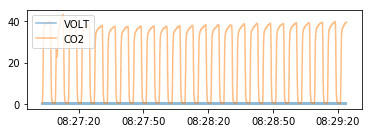

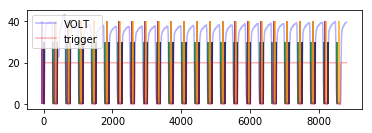

Breathing_start 23 Breathing_end 23
There is no margin to capture!
HPSS 22
draw_spectrum 22


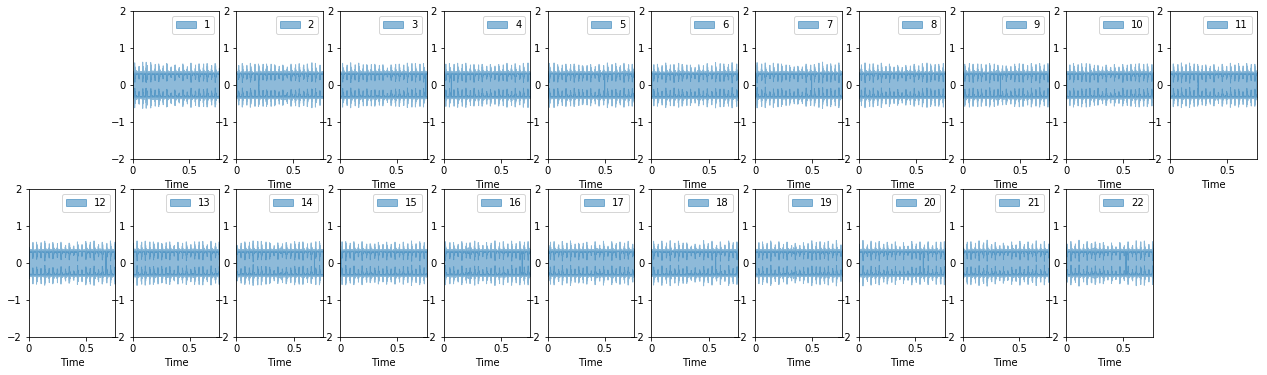

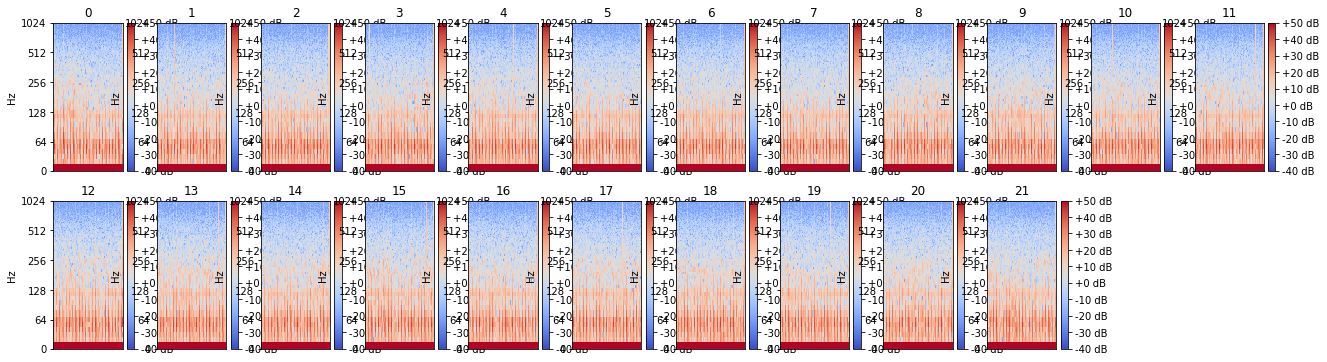

draw_MFCC 22


/home/keewon/.local/lib/python3.5/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


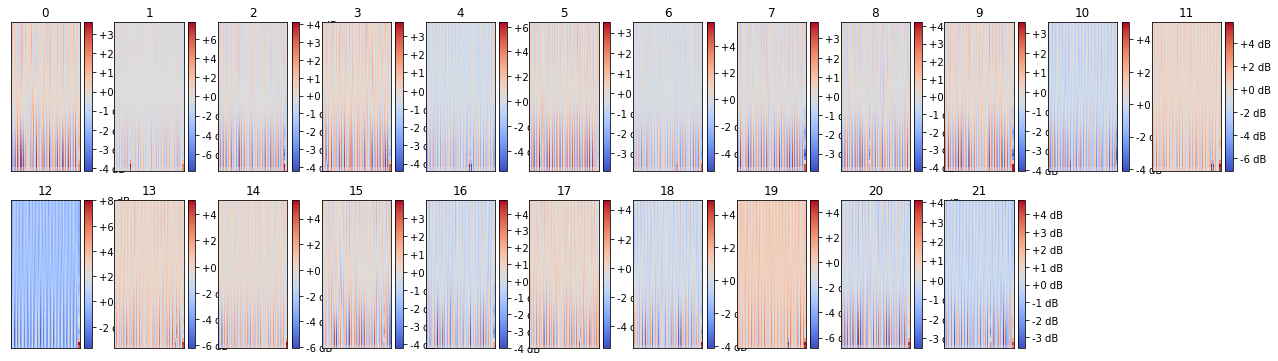

**********************************************************************
i = 5 [fname_with_time] 2018:7:11:8:29:24 to 2018:7:11:8:31:24_Lt OLV
j = 0 from device0
j = 1 from device2
new segment was found. 17877 1531273329.2204998 1531272461.5118876 30 62.5
                   Time_VOLT      VOLT                   Time_CO2   CO2
0 2018-07-11 08:29:24.000308  0.332357 2018-07-11 08:29:24.007547  39.5
1 2018-07-11 08:29:24.000708  0.334188 2018-07-11 08:29:24.023547  39.5
2 2018-07-11 08:29:24.001108  0.337850 2018-07-11 08:29:24.039546  39.5
**********************************************************************


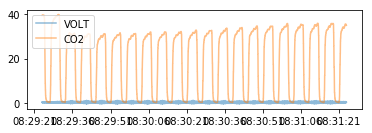

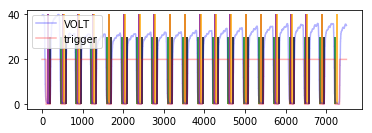

Breathing_start 19 Breathing_end 19
HPSS 19
draw_spectrum 19


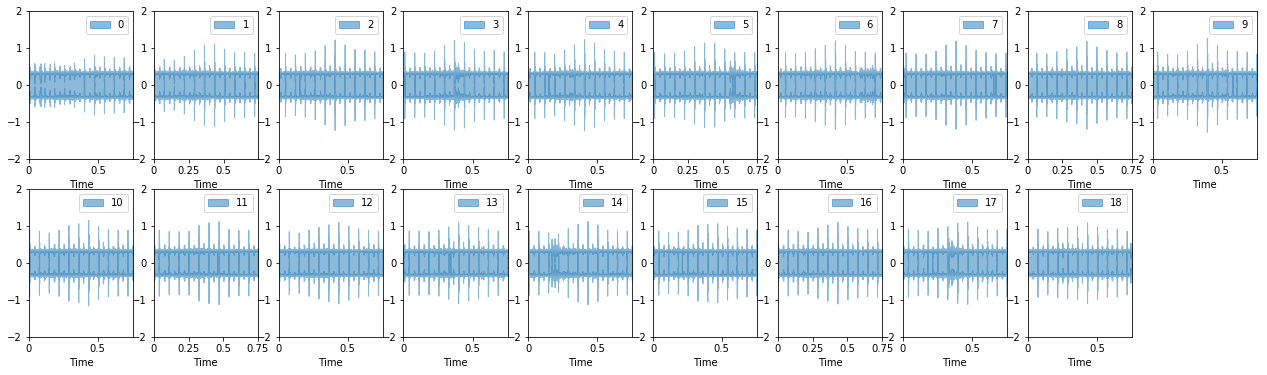

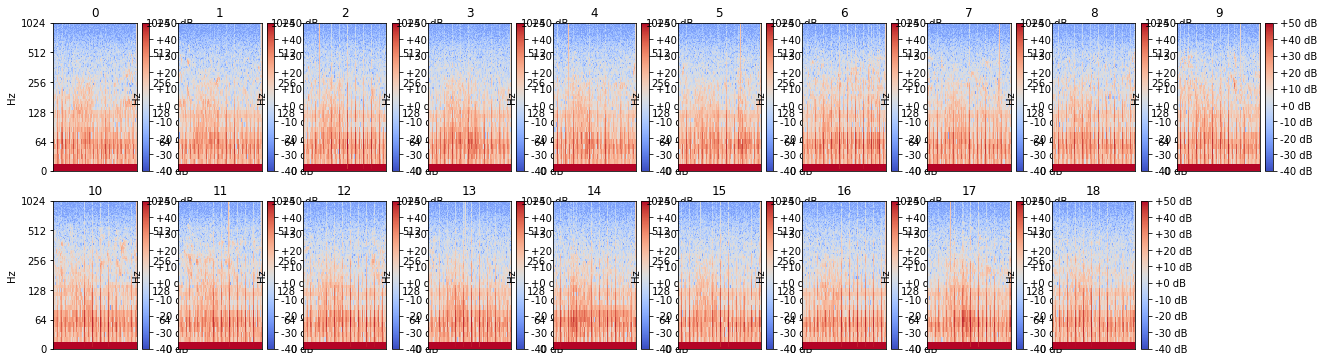

draw_MFCC 19


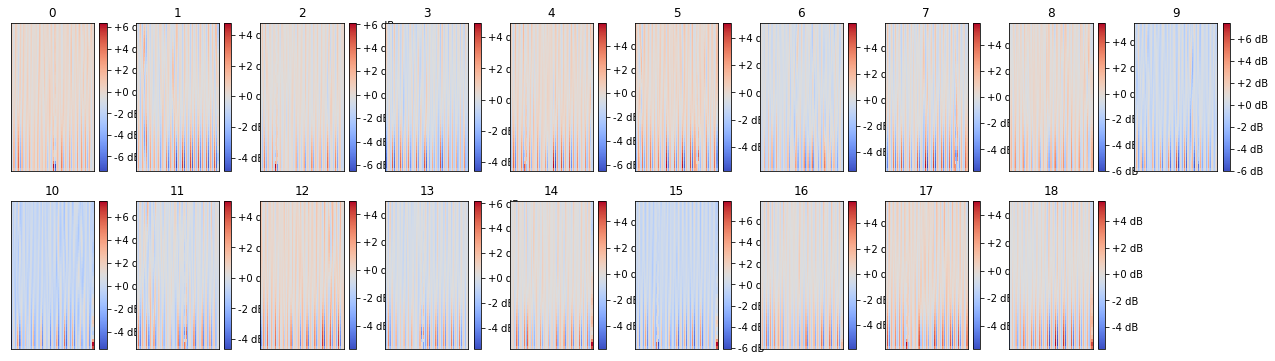

**********************************************************************
i = 6 [fname_with_time] 2018:7:11:8:31:24 to 2018:7:11:8:33:38_TLV
j = 0 from device0
j = 1 from device2
new segment was found. 17877 1531273329.2204998 1531272461.5118876 30 62.5
                   Time_VOLT      VOLT                   Time_CO2        CO2
0 2018-07-11 08:31:24.000308  0.348837 2018-07-11 08:31:24.007547  35.099998
1 2018-07-11 08:31:24.000708  0.350668 2018-07-11 08:31:24.023547  35.099998
2 2018-07-11 08:31:24.001108  0.352500 2018-07-11 08:31:24.039546  35.099998
**********************************************************************


IndexError: index 21 is out of bounds for axis 0 with size 21

In [4]:
# device0 : DI-1120
device0_name   = 'DI-1120'
device0_signal = ['VOLT']
#  blank if no signal to input []

# device1 : Intellivue
device1_name   = 'Intellivue'
device1_signal = []
#  blank if no signal to input []

# device2 : Primus
device2_name   = 'Primus'
device2_signal = ['CO2']
#  blank if no signal to input []

# devicedis = pd.read_csv('resource/vitalDB_device.csv')
# devicedis

print(len(device0_signal),'signal(s) from',device0_name)
print(len(device1_signal),'signal(s) from',device1_name)
print(len(device2_signal),'signal(s) from',device2_name)

for i in range(0,len(df_dict["Time"])-1):
    if df_dict["State"].isnull()[i] == False:
        if df_dict["State"][i]=="TLV" or df_dict["State"][i]=="Lt OLV" or df_dict["State"][i]=="Rt OLV" or df_dict["State"][i]=="VCM":
            fname_with_time = str(get_state_time(i)[0])+':'+str(get_state_time(i)[1])+':'+str(get_state_time(i)[2])+':'+str(get_state_time(i)[3])+':'+str(get_state_time(i)[4])+':'+str(get_state_time(i)[5])+' to '+str(get_state_time(i)[6])+':'+str(get_state_time(i)[7])+':'+str(get_state_time(i)[8])+':'+str(get_state_time(i)[9])+':'+str(get_state_time(i)[10])+':'+str(get_state_time(i)[11])+'_'+get_state_time(i)[12]
            print("*"*70)
            print('i =',i,'[fname_with_time]',fname_with_time)
            
            column_name=[]
            total_df=[]

            for j in range(0,len(device0_signal)+len(device1_signal)+len(device2_signal)):
                temp=[]
                if j<len(device0_signal):
                    print('j =',j,'from device0')
                    temp = vr_data.read_wave_datetime_interval(device0_name,device0_signal[j],datetime.datetime(get_state_time(j)[0],get_state_time(i)[1],get_state_time(i)[2],get_state_time(i)[3],get_state_time(i)[4],get_state_time(i)[5]),datetime.datetime(get_state_time(i)[6],get_state_time(i)[7],get_state_time(i)[8],get_state_time(i)[9],get_state_time(i)[10],get_state_time(i)[11]))
                    time_df = pd.DataFrame(temp[0])
                    signal_df = pd.DataFrame(temp[1])
                    total_df = pd.concat([time_df, signal_df],ignore_index=False, axis=1)

                    column_name.append("Time_"+device0_signal[j])
                    column_name.append(device0_signal[j])

                elif j<len(device0_signal)+len(device1_signal):
                    print('j =',j,'from device1')
                    temp = vr_data.read_number_datetime_interval(device1_name,device1_signal[j-len(device0_signal)],datetime.datetime(get_state_time(i)[0],get_state_time(i)[1],get_state_time(i)[2],get_state_time(i)[3],get_state_time(i)[4],get_state_time(i)[5]),datetime.datetime(get_state_time(i)[6],get_state_time(i)[7],get_state_time(i)[8],get_state_time(i)[9],get_state_time(i)[10],get_state_time(i)[11]))
                    time_df = pd.DataFrame(temp[0])
                    signal_df = pd.DataFrame(temp[1])
                    total_df = pd.concat([total_df,time_df, signal_df],ignore_index=False, axis=1)

                    column_name.append("Time_"+device1_signal[j-len(device0_signal)])
                    column_name.append(device1_signal[j-len(device0_signal)])

                else:
                    print('j =',j,'from device2')
                    temp = vr_data.read_wave_datetime_interval(device2_name,device2_signal[j-len(device0_signal)-len(device1_signal)],datetime.datetime(get_state_time(i)[0],get_state_time(i)[1],get_state_time(i)[2],get_state_time(i)[3],get_state_time(i)[4],get_state_time(i)[5]),datetime.datetime(get_state_time(i)[6],get_state_time(i)[7],get_state_time(i)[8],get_state_time(i)[9],get_state_time(i)[10],get_state_time(i)[11]))
                    time_df = pd.DataFrame(temp[0])
                    signal_df = pd.DataFrame(temp[1])
                    total_df = pd.concat([total_df,time_df, signal_df],ignore_index=False, axis=1)

                    column_name.append("Time_"+device2_signal[j-len(device0_signal)-len(device1_signal)])
                    column_name.append(device2_signal[j-len(device0_signal)-len(device1_signal)])

            total_df.columns = column_name
            print(total_df.head(3))
            print('*'*70)
            make_output_dirs()
            extract_original_wav()
            HPSS()
            draw_spectrum()
            draw_MFCC()

print("Processing finished!!!")